## Import Libraries

In [ ]:

pip install tensorflow

In [2]:
!pip install pydot


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install scikeras
!pip install keras
!pip install matplotlib
!pip install seaborn
!pip install librosa
!pip install os
!pip install sys
!pip install io
!pip install pickle

In [4]:
#Import required libraries
import os

import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

import tensorflow as tf
import glob
import IPython.display as ipd
import sys

import keras
from keras import layers
from keras.utils import plot_model
from keras.layers import Activation, Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from keras.models import model_from_json
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import random

import pickle
import seaborn as sns
import io
# from google.colab import files

#from google.colab import drive
#drive.mount('/content/drive')

## Utility functions

In [19]:
#function to parse file and extract corresponding emotion for savee dataset


def tess_data_parser(filepaths, path):
    audio_item = []
    emotion = []
    classID = []

    for i in filepaths:
        filename = os.listdir(os.path.join(path, i))  # Use os.path.join to construct the file path
        for f in filename:
            if i == 'OAF_angry' or i == 'YAF_angry':
                emotion.append('angry')
                classID.append(1)
            elif i == 'OAF_disgust' or i == 'YAF_disgust':
                emotion.append('disgust')
                classID.append(2)
            elif i == 'OAF_Fear' or i == 'YAF_fear':
                emotion.append('fear')
                classID.append(3)
            elif i == 'OAF_happy' or i == 'YAF_happy':
                emotion.append('happy')
                classID.append(4)
            elif i == 'OAF_neutral' or i == 'YAF_neutral':
                emotion.append('neutral')
                classID.append(5)
            elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
                emotion.append('surprise')
                classID.append(6)
            elif i == 'OAF_Sad' or i == 'YAF_sad':
                emotion.append('sad')
                classID.append(7)
            else:
                continue
            audio_item.append(os.path.join(path, i, f))  # Construct the full file path

    tess_df = pd.DataFrame(emotion, columns=['emotion'])
    tess_df['classID'] = classID
    tess_df = pd.concat([tess_df, pd.DataFrame(audio_item, columns=['audio_file'])], axis=1)

    return tess_df

def ravdess_data_parser(filepaths, path):
    audio_item = []
    emotion = []
    classID = []
    
    # Mapping from the emotion identifier to the emotion label and class ID
    emotion_map = {
        '01': ('neutral', 5),
        '03': ('happy', 4),
        '04': ('sad', 7),
        '05': ('angry', 1),
        '06': ('fear', 3),
        '07': ('disgust', 2),
        '08': ('surprise', 6)
    }
    
    for i in filepaths:
        filename = os.listdir(os.path.join(path, i))  # Use os.path.join to construct the file path
        for f in filename:
            parts = f.split('-')
            if len(parts) != 7:
                continue  # Skip files that do not follow the naming convention
            
            emotion_id = parts[2]
            if emotion_id == '02':  # Skip 'calm' emotion
                continue
            
            emotion_label, class_id = emotion_map.get(emotion_id, (None, None))
            if emotion_label is None:
                continue  # Skip if the emotion is not recognized
            
            emotion.append(emotion_label)
            classID.append(class_id)
            audio_item.append(os.path.join(path, i, f))  # Construct the full file path
    
    ravdess_df = pd.DataFrame(emotion, columns=['emotion'])
    ravdess_df['classID'] = classID
    ravdess_df = pd.concat([ravdess_df, pd.DataFrame(audio_item, columns=['audio_file'])], axis=1)
    
    return ravdess_df




#function to load raw data
def load_mel_all(df):

    mel_data = []
    targets = []

    for row in df.itertuples():
        y,sr = librosa.load(row.audio_file)
        mel = librosa.feature.melspectrogram(y=y, sr=sampling_rate, n_mels=128)
        mel_data.append(mel)
        targets.append(row.emotion)

    return [mel_data, targets]






def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')







#plot training and testing validation accuracy and loss
def plot_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1)
    print(epochs)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def fit_model(model, X_train, y_train,X_val, y_val, epochs):

    #define callbacks
    callbacks_list = [
                    keras.callbacks.EarlyStopping(
                        monitor = 'acc',
                        patience = 1,
                        mode = 'max'
                    )]

    #fit and evaluate model
    history = model.fit(x=X_train,
            y = y_train,
            epochs=epochs,
            batch_size=50,
            callbacks = callbacks_list,
            validation_data = (X_val, y_val))

    score = model.evaluate(x = X_val,
                        y = y_val)

    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])

    return history, score


import os

def save_model(model, model_name, filename):
    # Save model and weights
    model_name = model_name
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '.h5')
    model.save(model_path)
    print('Saving model and weights at %s ' % model_path)

    # Save the model to disk
    model_json = model.to_json()
    with open(filename, "w") as json_file:
        json_file.write(model_json)


def load_model(filename, model_name):
    # loading json and model architecture
    json_file = open(filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights("saved_models/" + model_name + '.keras')  # Use '.h5' extension
    print("Loaded model from disk")
    return loaded_model


def OneD_CNN(input_shape):

    model = Sequential()

    model.add(Conv1D(256, 8, padding='same', activation="relu",input_shape=input_shape))

    model.add(Conv1D(256, 8, padding='same', activation="relu"))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(64, 8, padding='same', activation="relu"))

    model.add(Conv1D(64, 8, padding='same', activation="relu"))

    #model.add(Flatten())

    model.add(layers.LSTM(256))

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(7))
    model.add(Activation('softmax'))


    model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics = ['accuracy'])

    return model



## Data Collection and Exploration

In [6]:
#prepare TESS data
tess_data_path = r"F:\SpeechEmotionRecognition\TESS Toronto emotional speech set data"
tess_audio = os.listdir(tess_data_path)
tess_audio.sort()
tess_audio

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'TESS Toronto emotional speech set data',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [7]:
ravdess_data_path = r"F:\SpeechEmotionRecognition\dataset\RAVDESS_dataset"
ravdess_audio = os.listdir(ravdess_data_path)
ravdess_audio.sort()
ravdess_audio

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [8]:
tess_df = tess_data_parser(tess_audio, tess_data_path)
ravdess_df = ravdess_data_parser(ravdess_audio, ravdess_data_path)
combined_df = pd.concat([tess_df, ravdess_df], ignore_index=True)

<Figure size 1500x500 with 0 Axes>

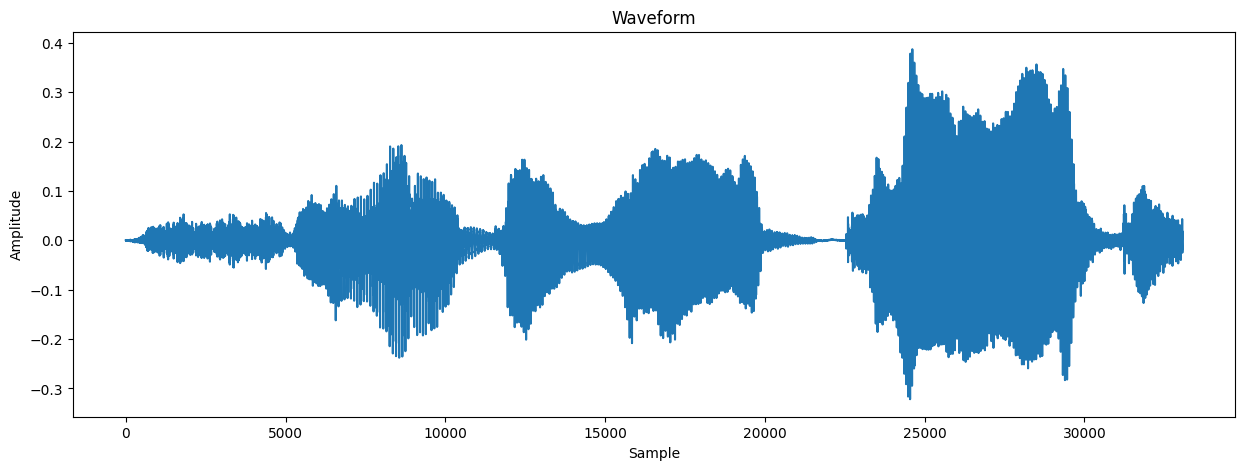

In [9]:
#Explore data TESS

# play a fearful track 
# fname = tess_data_path + 'YAF_fear/YAF_dog_fear.wav' 
fname = os.path.join(tess_data_path, 'YAF_fear', 'YAF_dog_fear.wav')

data, sampling_rate = librosa.load(fname, duration=1.5)
plt.figure(figsize=(15, 5))
# librosa.display.waveplot(data, sr=sampling_rate)
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(data)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

#play the audio 
ipd.Audio(fname)

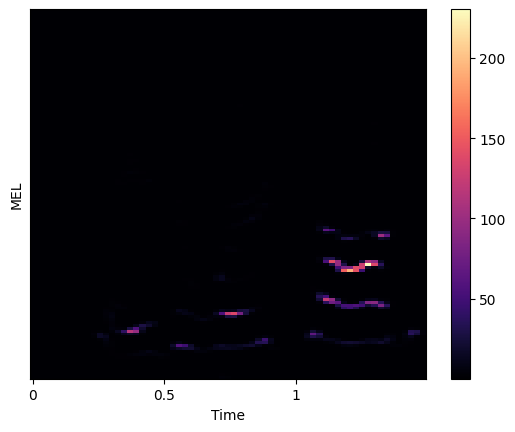

In [10]:
#plot Log Mel spectogram for TESS data sample
mel = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128)

librosa.display.specshow(mel, x_axis='time')
plt.ylabel('MEL')
plt.colorbar()
plt.show()

### Second Approach to model training using the full length of the recordings

**Load all the data and take mean of the time axis to reduce dimensions**

In [11]:
tess_all = load_mel_all(combined_df)

In [12]:
X = tess_all[0]
y = tess_all[1]

In [13]:
f = [np.mean(c, axis=0) for c in X]

In [14]:
s = pd.DataFrame(f)
s

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,0.000208,0.000353,0.000249,2.586271e-04,5.047327e-04,7.800792e-04,9.616225e-04,1.516106e-03,2.000814e-03,2.083288e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000078,0.000146,0.000141,8.037292e-04,1.549025e-03,2.332961e-03,4.066971e-03,5.406343e-03,6.060374e-03,6.161802e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000022,0.000128,0.000183,3.226881e-04,9.328296e-04,1.853263e-03,3.174986e-03,4.437734e-03,5.177184e-03,4.975202e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000188,0.000331,0.000107,2.783810e-04,7.278688e-04,1.114704e-03,2.013223e-03,2.877515e-03,3.785030e-03,4.667748e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000115,0.000097,0.000123,3.279960e-04,9.225940e-05,1.193739e-04,3.060341e-04,6.650941e-04,1.564744e-03,3.075922e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4044,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4045,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4046,0.000000,0.000000,0.000000,6.688781e-24,4.203038e-13,5.452949e-08,1.966800e-07,4.515154e-08,1.201346e-10,9.061915e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
t = s.fillna(0)

In [16]:
t.shape

(4048, 228)

In [20]:
def prepare1D(X, y):
    # Ensure X and y have the same length
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")

    # Split each into train, test, and validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    # Convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Reshape for CNN
    X_train = np.array([x.reshape((228, 1)) for x in X_train])
    X_val = np.array([x.reshape((228, 1)) for x in X_val])
    X_test = np.array([x.reshape((228, 1)) for x in X_test])

    # One hot encode the target
    lb = LabelEncoder()
    lb.fit(y_train)
    y_train = keras.utils.to_categorical(lb.transform(y_train))
    y_test = keras.utils.to_categorical(lb.transform(y_test))
    y_val = keras.utils.to_categorical(lb.transform(y_val))

    return X_train, y_train, X_test, y_test, X_val, y_val

def pad_data(X):
    # Calculate the number of elements needed to make the length a multiple of 129
    remainder = 129 - (len(X) % 129)
    if remainder > 0:
        # Pad the data with zeros
        X = np.concatenate((X, np.zeros((remainder, X.shape[1]))))
    return X

# Example usage


In [21]:
X_train, y_train, X_test, y_test, X_val, y_val =  prepare1D(t, y)

In [22]:
model = OneD_CNN((228,1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 228, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 228, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 228, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 28, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 28, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 28, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 3, 64)          │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 64)          │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,677,959 (6.40 MB)

 Trainable params: 1,677,703 (6.40 MB)

 Non-trainable params: 256 (1.00 KB)

In [23]:
epochs = 15
history, score = fit_model(model,X_train, y_train,X_val, y_val,epochs)

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.2675 - loss: 1.8004 - val_accuracy: 0.3182 - val_loss: 1.6824
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.3588 - loss: 1.5334 - val_accuracy: 0.4102 - val_loss: 1.4538
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.5296 - loss: 1.1583 - val_accuracy: 0.5254 - val_loss: 1.2174
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - accuracy: 0.5742 - loss: 0.9986 - val_accuracy: 0.5857 - val_loss: 1.0181
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.6737 - loss: 0.8315 - val_accuracy: 0.6694 - val_loss: 0.8754
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.7427 - loss: 0.6676 - val_accuracy: 0.7188 - val_loss: 0.9254
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - accuracy: 0.7346 - loss: 0.6811 - val_accuracy: 0.7202 - val_loss: 0.8807
Epoch 8/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.7686 - loss: 0.6103 - val_accu

range(1, 16)


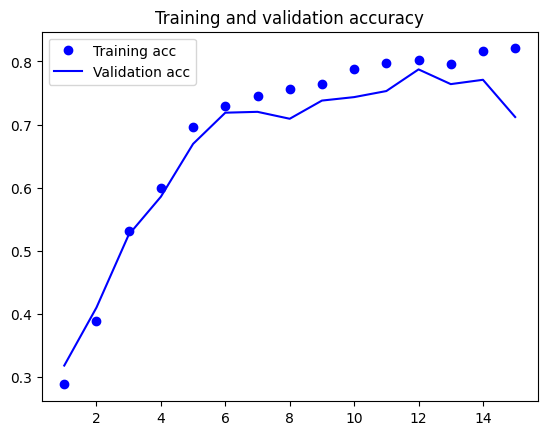

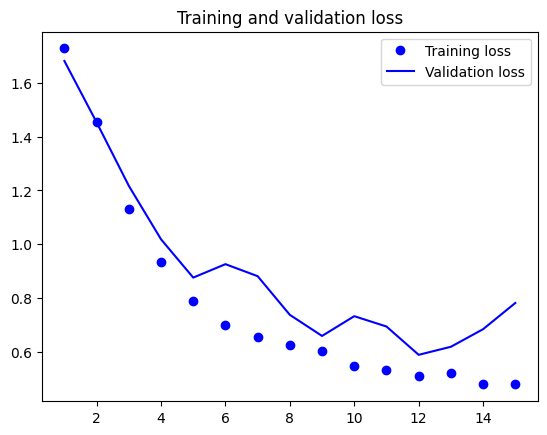

In [24]:
plot_model(history)

In [25]:
#use model to make predictions
preds = model.predict(X_test, 
                      batch_size=50, 
                      verbose=1)

preds=preds.argmax(axis=1)
preds

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


array([5, 6, 2, 1, 0, 6, 0, 0, 2, 1, 5, 3, 5, 0, 2, 2, 6, 6, 1, 3, 3, 1,
       2, 3, 1, 1, 3, 0, 6, 5, 1, 3, 5, 2, 1, 5, 6, 0, 0, 0, 2, 2, 2, 5,
       0, 2, 6, 1, 6, 2, 5, 1, 2, 6, 5, 0, 6, 3, 2, 3, 3, 0, 5, 0, 3, 1,
       1, 0, 5, 0, 0, 3, 1, 5, 2, 2, 0, 4, 1, 6, 0, 6, 2, 2, 1, 6, 2, 1,
       1, 2, 6, 1, 2, 5, 3, 5, 0, 6, 0, 2, 2, 3, 2, 0, 6, 5, 5, 5, 1, 5,
       5, 3, 3, 4, 3, 2, 2, 3, 3, 1, 1, 1, 5, 4, 5, 0, 5, 5, 2, 0, 5, 5,
       5, 3, 1, 2, 0, 5, 2, 2, 5, 1, 1, 3, 0, 2, 4, 5, 3, 2, 1, 5, 2, 3,
       2, 5, 5, 6, 5, 0, 5, 5, 5, 1, 2, 5, 0, 5, 0, 0, 3, 3, 0, 4, 5, 2,
       3, 0, 5, 6, 1, 5, 6, 6, 1, 6, 0, 3, 2, 2, 0, 2, 5, 3, 1, 5, 0, 4,
       6, 5, 6, 5, 2, 2, 5, 5, 2, 5, 3, 0, 5, 4, 3, 5, 5, 1, 2, 0, 0, 0,
       3, 5, 6, 5, 3, 1, 2, 0, 2, 5, 4, 5, 5, 2, 1, 1, 5, 5, 2, 1, 2, 5,
       0, 2, 2, 2, 5, 2, 0, 3, 2, 3, 2, 0, 3, 5, 3, 2, 1, 6, 4, 5, 2, 5,
       5, 2, 3, 2, 4, 1, 2, 1, 2, 2, 3, 1, 5, 5, 5, 5, 2, 0, 2, 1, 2, 3,
       5, 5, 6, 5, 1, 1, 3, 5, 2, 5, 5, 3, 5, 5, 2,

In [ ]:
# #save model
# save_model(model,'oneDcnnall.h5','oneDcnnall')

In [27]:
import pickle

In [30]:
pickle.dump(model, open('model.pkl', 'wb'))